# Human Silhouettes Detector
---
Detector of human sulhouettes.

In [1]:
import os
import csv
import numpy as np
import pandas as pd

import pickle

from PIL import Image

from src.human_silhouette_detector import (detect_human_silhouettes,
                                           detect_human_silhouettes_and_faces)
from src.face_detector import inference
from src.perc_calculation import intersects
from src.visualize import show_images

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'MainModel.KitModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by access

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
img1 = Image.open('images/unmasked_people1.jpg')
img1_info, img1 = detect_human_silhouettes(img1)

img2 = Image.open('images/unmasked_people2.jpg')
img2_info, img2 = detect_human_silhouettes(img2)

img3 = Image.open('images/unmasked_people3.jpg')
img3_info, img3 = detect_human_silhouettes(img3)

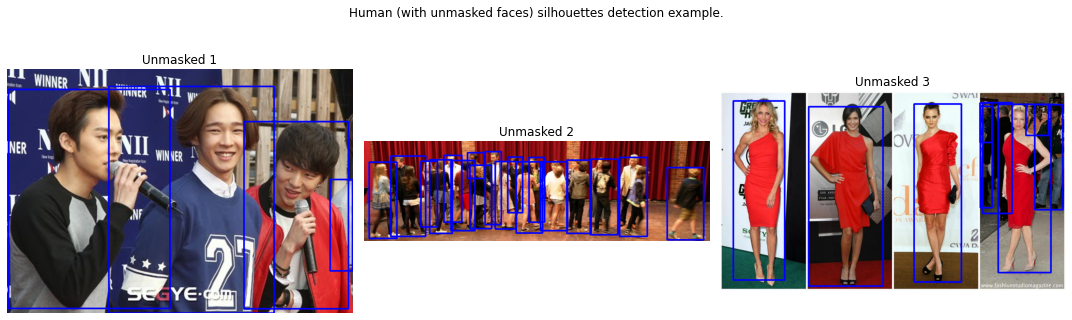

In [4]:
show_images([img1, img2, img3],
            ['Unmasked 1', 'Unmasked 2', 'Unmasked 3'],
            suptitle='Human (with unmasked faces) silhouettes detection example.')

In [5]:
img1 = Image.open('images/masked_people1.jpg')
img1_info, img1 = detect_human_silhouettes(img1)

img2 = Image.open('images/masked_people2.jpg')
img2_info, img2 = detect_human_silhouettes(img2)

img3 = Image.open('images/masked_people3.jpg')
img3_info, img3 = detect_human_silhouettes(img3)

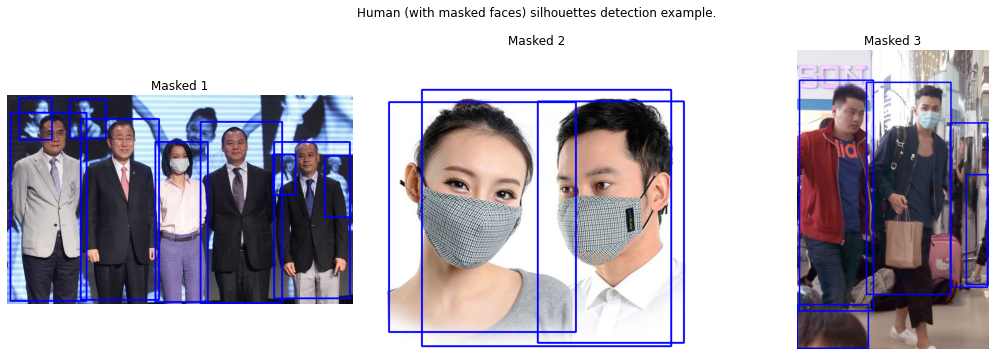

In [6]:
show_images([img1, img2, img3],
            ['Masked 1', 'Masked 2', 'Masked 3'],
            suptitle='Human (with masked faces) silhouettes detection example.')

In [7]:
img1 = Image.open('images/masked_criminal1.png')
img1_info, img1 = detect_human_silhouettes(img1)

img2 = Image.open('images/masked_criminal2.png')
img2_info, img2 = detect_human_silhouettes(img2)

img3 = Image.open('images/masked_criminal3.png')
img3_info, img3 = detect_human_silhouettes(img3)

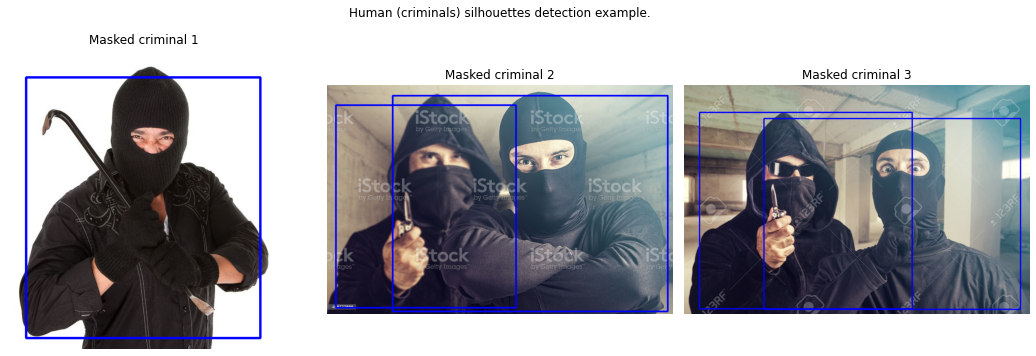

In [8]:
show_images([img1, img2, img3],
            ['Masked criminal 1', 'Masked criminal 2', 'Masked criminal 3'],
            suptitle='Human (criminals) silhouettes detection example.')

## Silhouette and face dependencies
---
Searching for dependencies between silhouette and face positions.
1. Save .csv header row \['img_name', 'silh_x1', 'silh_y1', 'silh_x2', 'silh_y2', 'faceimg_name', 'face_x1', 'face_y1', 'face_x2', 'face_y2'\].
2. For each image.png:
    1. Detect silhouettes.
    2. For each detected silhouette region:
        1. Detect faces.
        2. For each detected face region:
            1. Save detected face as face_x.png.
            2. Save .csv row \['image.png', 'sx1', 'sy1', 'sx2', 'sy2', 'face_x.png', 'fx1', 'fy1', 'fx2', 'fy2'\].

In [9]:
IMG_FOLDER = 'silh_images'
FACES_FOLDER = 'detected_faces'
OUT_CSV = 'silhfaces_positions.csv'

In [10]:
if not os.path.exists(OUT_CSV):
    with open(OUT_CSV, 'w') as f:
        csv.writer(f).writerow(['img_name', 'silh_x1', 'silh_y1', 'silh_x2', 'silh_y2',
                               'faceimg_name', 'face_x1', 'face_y1', 'face_x2', 'face_y2'])
    ctr = 0
    t = tqdm(sorted(os.listdir(IMG_FOLDER)))
    for img_name in t:
        
        t.set_postfix_str(f'Curr. img.: {img_name} | Faces found: {ctr}')
        img = Image.open(f'{IMG_FOLDER}/{img_name}')
        img_arr = np.array(img)
        
        try:
            silhs, _ = detect_human_silhouettes(img_arr)
            faces, _ = inference(img_arr)
            for face in faces:
                fx1, fy1, fx2, fy2 = tuple(face[2:])
                
                face_path = f'{FACES_FOLDER}/face{ctr}.png'
                face_img = Image.fromarray(img_arr[fy1:fy2, fx1:fx2])
                face_img.save(face_path)
                for silh in silhs:
                    x1, y1, x2, y2 = tuple(np.array(silh, dtype=np.int32))
                    
                    # if exists intersection between silhouette and face rectangles
                    if intersects(x1, y1, x2, y2, fx1, fy1, fx2, fy2):
                        with open(OUT_CSV, 'a') as f:
                            csv.writer(f).writerow([img_name, x1, y1, x2, y2,
                                                    f'face{ctr}.png', fx1, fy1, fx2, fy2])
                ctr += 1
        except:
            pass

Annotate detected faces whether:
 - **-1** - it's not a face
 - **0** - it's a face without mask or uncorrectly put on mask
 - **1** - it's a face with correctly put on mask

Train DecisionTree model to predict (having two points of silhouette and two of potential face) whether the detection is face or not.

In [11]:
POSITIONS_CSV = 'silhfaces_positions.csv'
ANNOTATIONS_CSV = 'detected_faces_annotations_all.csv'

MM_SC_PATH = 'src/models/mm_sc.pkl'
DT_POS_PATH = 'src/models/dt_pos.pkl'

In [12]:
df_positions = pd.read_csv(POSITIONS_CSV)
df_positions.head(2)

,img_name,silh_x1,silh_y1,silh_x2,silh_y2,faceimg_name,face_x1,face_y1,face_x2,face_y2
0,13_Interview_Interview_2_People_Visible_13_101...,14,6,406,684,face0.png,149,85,303,281
1,13_Interview_Interview_2_People_Visible_13_101...,369,173,864,683,face1.png,542,220,717,446


In [13]:
df_annotations = pd.read_csv(ANNOTATIONS_CSV)
df_annotations.head(2)

,File,Class
0,face0.png,0
1,face1.png,0


In [14]:
df_combine = df_positions.merge(df_annotations, left_on='faceimg_name',
                                right_on='File').drop(['img_name', 'faceimg_name', 'File'], axis=1)
df_combine['Class'] = df_combine['Class'].map({-1: 0, 0: 1, 1: 1})  # 0 - no face; 1 - face
df_combine = df_combine.sample(frac = 1) 
df_combine

,silh_x1,silh_y1,silh_x2,silh_y2,face_x1,face_y1,face_x2,face_y2,Class
890,103,21,631,456,218,136,445,428,1
7464,111,115,683,793,169,169,430,529,1
1460,671,179,1024,601,540,77,740,400,1
8540,79,5,331,626,269,281,436,530,1
1495,8,80,506,711,206,150,323,304,1
...,...,...,...,...,...,...,...,...,...
2395,39,72,403,669,166,120,266,237,1
1272,0,59,280,655,27,172,228,458,1
2952,694,68,882,351,717,134,794,220,1
4582,748,97,900,496,770,113,812,167,0


In [15]:
if not os.path.exists(MM_SC_PATH):
    sc_x, sc_y = MinMaxScaler(), MinMaxScaler()
    silh_x = sc_x.fit_transform(df_combine[['silh_x1', 'silh_x2']].values)
    silh_y = sc_y.fit_transform(df_combine[['silh_y1', 'silh_y2']].values)
    face_x = sc_x.transform(df_combine[['face_x1', 'face_x2']].values)
    face_y = sc_y.transform(df_combine[['face_y1', 'face_y2']].values)
    
    with open(MM_SC_PATH, 'wb') as f:
        pickle.dump([sc_x, sc_y], f)
else:
    with open(MM_SC_PATH, 'rb') as f:
        sc_x, sc_y = tuple(pickle.load(f))
    silh_x = sc_x.transform(df_combine[['silh_x1', 'silh_x2']].values)
    silh_y = sc_y.transform(df_combine[['silh_y1', 'silh_y2']].values)
    face_x = sc_x.transform(df_combine[['face_x1', 'face_x2']].values)
    face_y = sc_y.transform(df_combine[['face_y1', 'face_y2']].values)

In [16]:
df_combine['silh_x1'] = silh_x[:, ::2].reshape(-1)
df_combine['silh_y1'] = silh_y[:, ::2].reshape(-1)
df_combine['silh_x2'] = silh_x[:, 1::2].reshape(-1)
df_combine['silh_y2'] = silh_y[:, 1::2].reshape(-1)

df_combine['face_x1'] = face_x[:, ::2].reshape(-1)
df_combine['face_y1'] = face_y[:, ::2].reshape(-1)
df_combine['face_x2'] = face_x[:, 1::2].reshape(-1)
df_combine['face_y2'] = face_y[:, 1::2].reshape(-1)

df_combine

,silh_x1,silh_y1,silh_x2,silh_y2,face_x1,face_y1,face_x2,face_y2,Class
890,0.065647,0.018229,0.311467,0.142541,0.138942,0.118056,0.215393,0.132228,1
7464,0.070746,0.099826,0.338326,0.266667,0.107712,0.146701,0.207645,0.169429,1
1460,0.427661,0.155382,0.514463,0.195948,0.344168,0.066840,0.367769,0.121915,1
8540,0.050351,0.004340,0.156508,0.205157,0.171447,0.243924,0.210744,0.169797,1
1495,0.005099,0.069444,0.246901,0.236464,0.131294,0.130208,0.152376,0.086556,1
...,...,...,...,...,...,...,...,...,...
2395,0.024857,0.062500,0.193698,0.220994,0.105800,0.104167,0.122934,0.061878,1
1272,0.000000,0.051215,0.130165,0.215838,0.017208,0.149306,0.103306,0.143278,1
2952,0.442320,0.059028,0.441116,0.103867,0.456979,0.116319,0.395661,0.055617,1
4582,0.476737,0.084201,0.450413,0.157274,0.490758,0.098090,0.404959,0.036096,0


In [17]:
if not os.path.exists(DT_POS_PATH):
    X = df_combine.drop('Class', axis=1).values
    y = df_combine['Class'].values
    
    skf = StratifiedKFold(n_splits=5)
    
    best_mf, best_mnf = 0., 0.  # best mean and st.dev. f1

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = DecisionTreeClassifier(random_state=0, class_weight='balanced')
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        a = accuracy_score(y_true=y_test, y_pred=y_pred)
        f = f1_score(y_true=y_test, y_pred=y_pred, average=None, zero_division=1)

        mf = np.mean(f)
        mnf = np.min(f)
        # save model if mean and min f1 is better than previous value
        if mf > best_mf and mnf > best_mnf:
            best_mf = mf
            best_mnf = mnf

            print(f'TEST IDX: [{test_index[0]}:{test_index[-1]}] | Acc.: {a} | F1: {f} --> Saved!')

            with open('src/models/dt_pos.pkl', 'wb') as f:
                pickle.dump(clf, f)
        else:
            print(f'TEST IDX: [{test_index[0]}:{test_index[-1]}] | Acc.: {a} | F1: {f}')

### Examples

In [18]:
img1 = Image.open('images/unmasked_people1.jpg')
img1_pos, img1_neg, img1 = detect_human_silhouettes_and_faces(img1, highlight_neg=True)

img2 = Image.open('images/unmasked_people2.jpg')
img2_pos, img2_neg, img2 = detect_human_silhouettes_and_faces(img2, highlight_neg=True)

img3 = Image.open('images/unmasked_people3.jpg')
img3_pos, img3_neg, img3 = detect_human_silhouettes_and_faces(img3, highlight_neg=True)

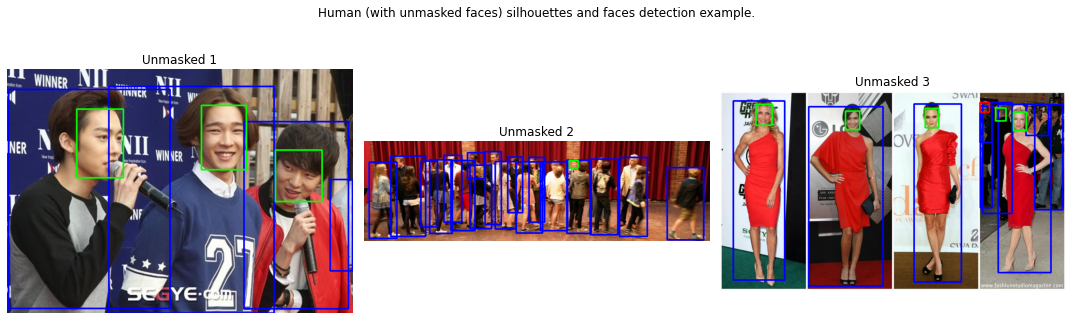

In [19]:
show_images([img1, img2, img3],
            ['Unmasked 1', 'Unmasked 2', 'Unmasked 3'],
            suptitle='Human (with unmasked faces) silhouettes and faces detection example.')

In [20]:
img1 = Image.open('images/masked_people1.jpg')
img1_pos, img1_neg, img1 = detect_human_silhouettes_and_faces(img1, highlight_neg=True)

img2 = Image.open('images/masked_people2.jpg')
img2_pos, img2_neg, img2 = detect_human_silhouettes_and_faces(img2, highlight_neg=True)

img3 = Image.open('images/masked_people3.jpg')
img3_pos, img3_neg, img3 = detect_human_silhouettes_and_faces(img3, highlight_neg=True)

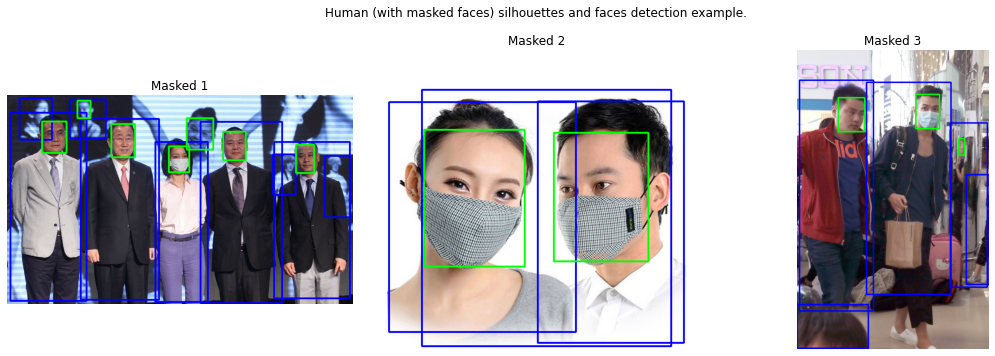

In [21]:
show_images([img1, img2, img3],
            ['Masked 1', 'Masked 2', 'Masked 3'],
            suptitle='Human (with masked faces) silhouettes and faces detection example.')

In [22]:
img1 = Image.open('images/masked_criminal1.png')
img1_pos, img1_neg, img1 = detect_human_silhouettes_and_faces(img1, highlight_neg=True)

img2 = Image.open('images/masked_criminal2.png')
img2_pos, img2_neg, img2 = detect_human_silhouettes_and_faces(img2, highlight_neg=True)

img3 = Image.open('images/masked_criminal3.png')
img3_pos, img3_neg, img3 = detect_human_silhouettes_and_faces(img3, highlight_neg=True)

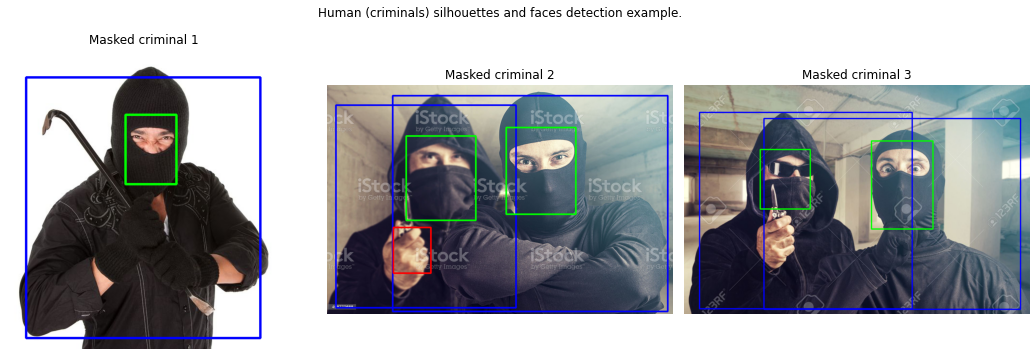

In [23]:
show_images([img1, img2, img3],
            ['Masked criminal 1', 'Masked criminal 2', 'Masked criminal 3'],
            suptitle='Human (criminals) silhouettes and faces detection example.')